In [17]:
import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42

In [18]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

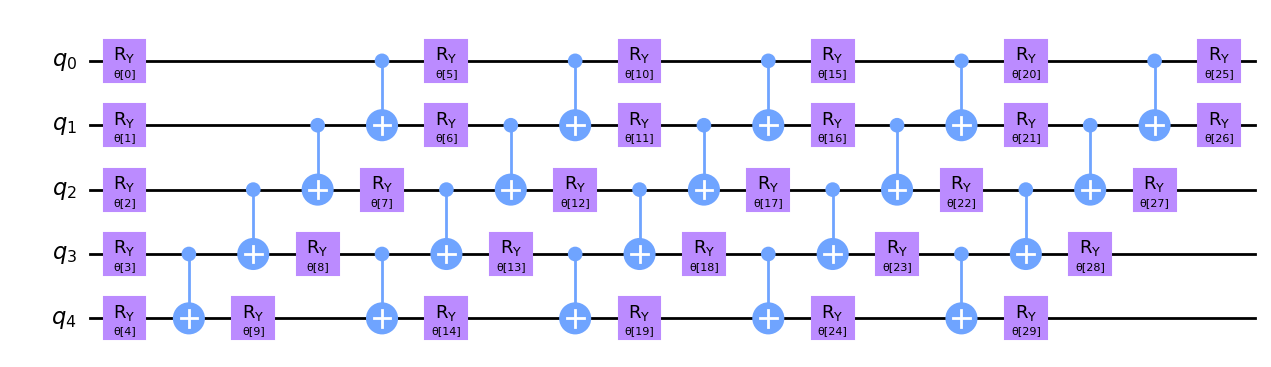

In [19]:
num_qubits = 5
circ = ansatz(num_qubits)
circ.decompose().draw(output="mpl", style="clifford")

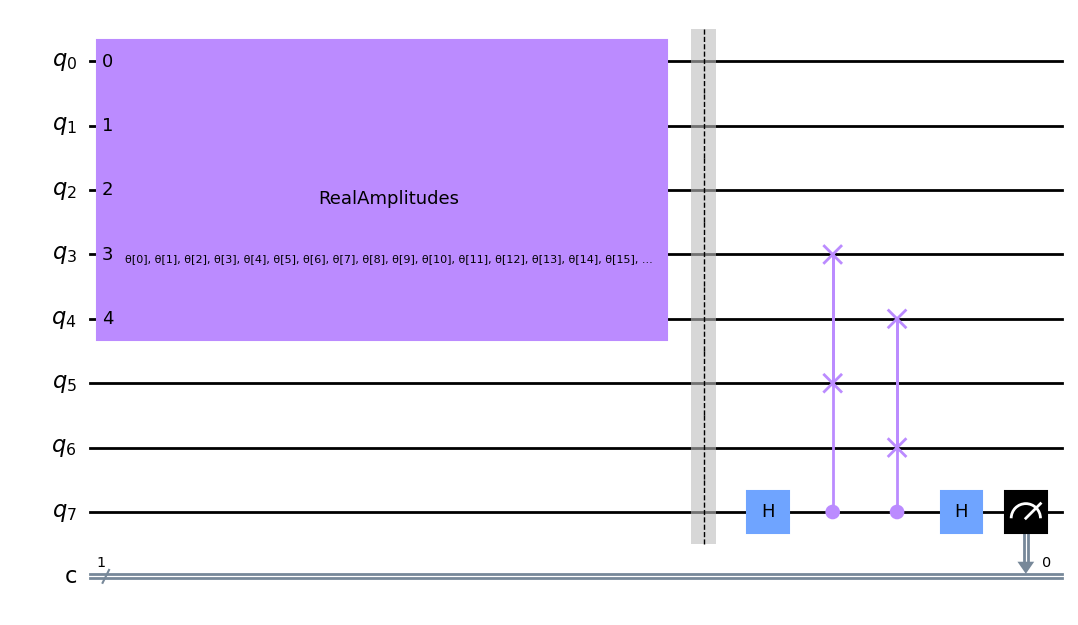

In [20]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit


num_latent = 3
num_trash = 2
circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw(output="mpl", style="clifford")

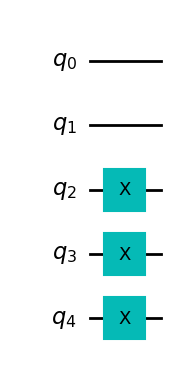

In [21]:
def domain_wall(circuit, a, b):
    # Here we place the Domain Wall to qubits a - b in our circuit
    for i in np.arange(int(b / 2), int(b)):
        circuit.x(i)
    return circuit


domain_wall_circuit = domain_wall(QuantumCircuit(5), 0, 5)
domain_wall_circuit.draw("mpl", style="clifford")

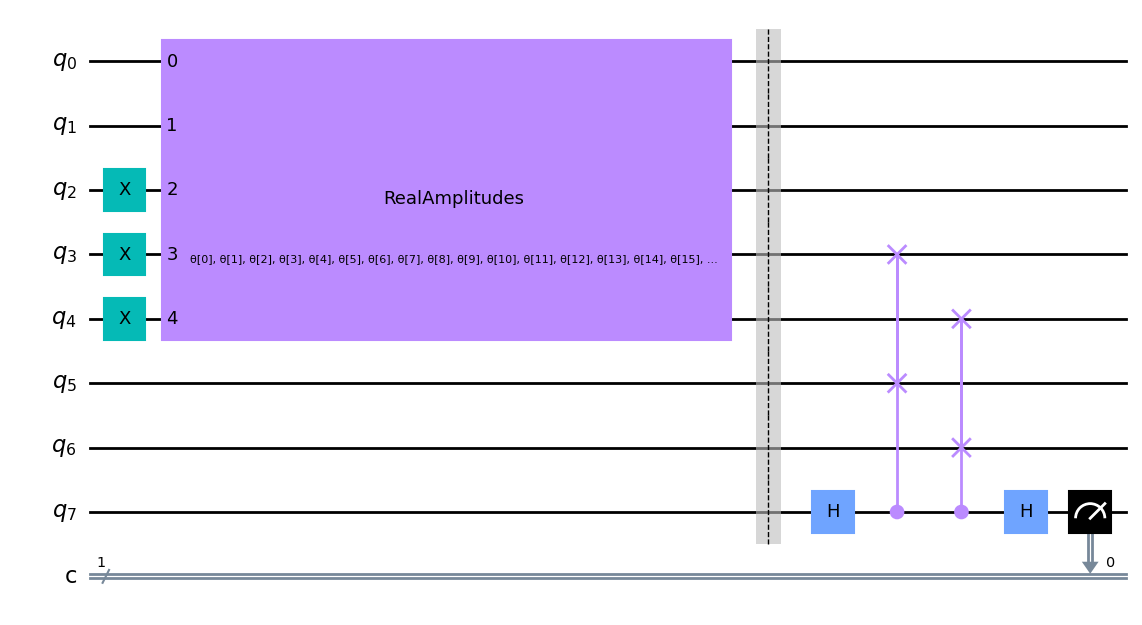

In [22]:
ae = auto_encoder_circuit(num_latent, num_trash)
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(domain_wall_circuit, range(num_latent + num_trash))
qc = qc.compose(ae)
qc.draw(output="mpl", style="clifford")

In [23]:
# Here we define our interpret for our SamplerQNN
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=[],
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [24]:
def cost_func_domain(params_values):
    probabilities = qnn.forward([], params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

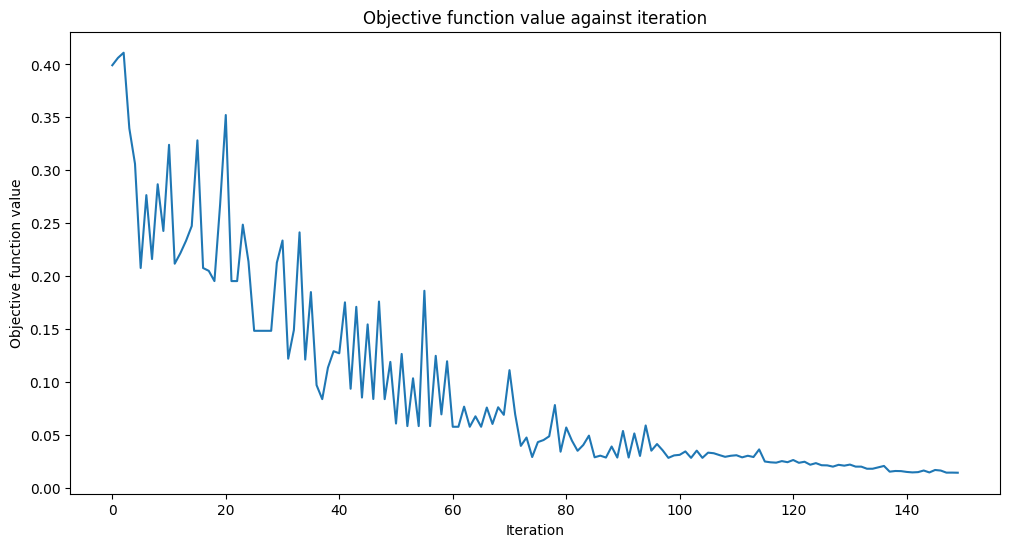

Fit in 27.51 seconds


In [25]:
opt = COBYLA(maxiter=150)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(cost_func_domain, initial_point)
elapsed = time.time() - start

print(f"Fit in {elapsed:0.2f} seconds")

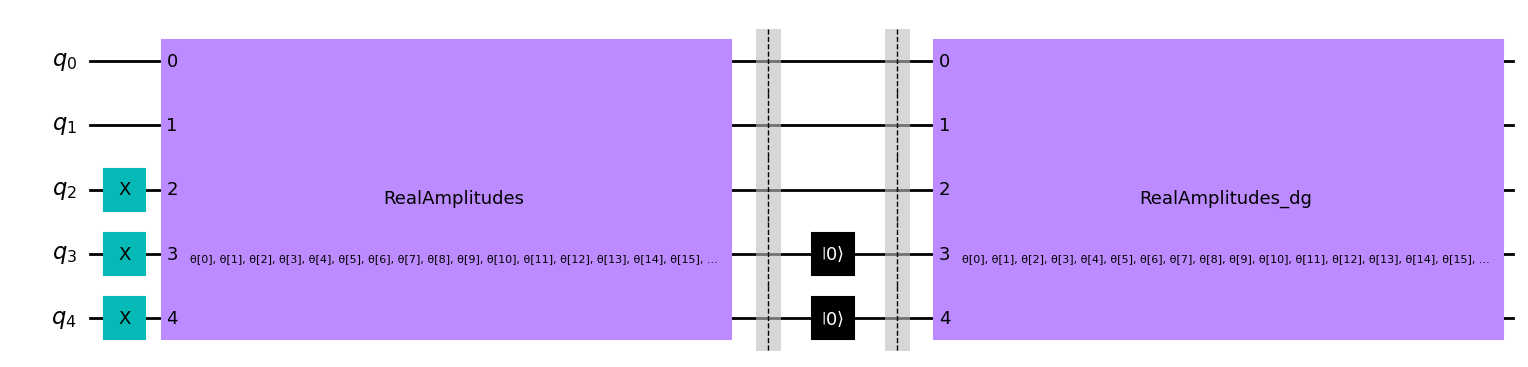

In [26]:
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(domain_wall_circuit)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

test_qc.draw(output="mpl", style="clifford")

In [27]:
test_qc = test_qc.assign_parameters(opt_result.x)

In [28]:
domain_wall_state = Statevector(domain_wall_circuit).data
output_state = Statevector(test_qc).data

fidelity = np.sqrt(np.dot(domain_wall_state.conj(), output_state) ** 2)
print("Fidelity of our Output State with our Input State: ", fidelity.real)

Fidelity of our Output State with our Input State:  0.9854280347279166


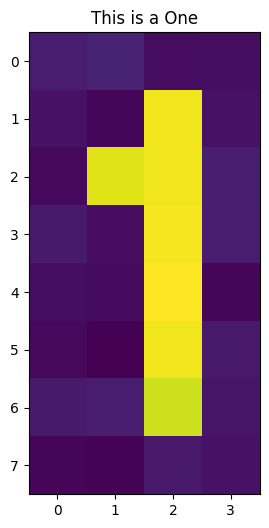

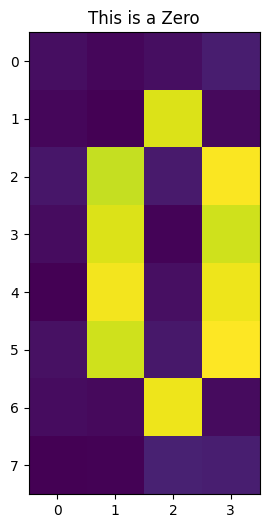

In [29]:
def zero_idx(j, i):
    # Index for zero pixels
    return [
        [i, j],
        [i - 1, j - 1],
        [i - 1, j + 1],
        [i - 2, j - 1],
        [i - 2, j + 1],
        [i - 3, j - 1],
        [i - 3, j + 1],
        [i - 4, j - 1],
        [i - 4, j + 1],
        [i - 5, j],
    ]


def one_idx(i, j):
    # Index for one pixels
    return [[i, j - 1], [i, j - 2], [i, j - 3], [i, j - 4], [i, j - 5], [i - 1, j - 4], [i, j]]


def get_dataset_digits(num, draw=True):
    # Create Dataset containing zero and one
    train_images = []
    train_labels = []
    for i in range(int(num / 2)):
        # First we introduce background noise
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(
            8, 4
        )

        # Now we insert the pixels for the one
        for i, j in one_idx(2, 6):
            empty[j][i] = algorithm_globals.random.uniform(0.9, 1)
        train_images.append(empty)
        train_labels.append(1)
        if draw:
            plt.title("This is a One")
            plt.imshow(train_images[-1])
            plt.show()

    for i in range(int(num / 2)):
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(
            8, 4
        )

        # Now we insert the pixels for the zero
        for k, j in zero_idx(2, 6):
            empty[k][j] = algorithm_globals.random.uniform(0.9, 1)

        train_images.append(empty)
        train_labels.append(0)
        if draw:
            plt.imshow(train_images[-1])
            plt.title("This is a Zero")
            plt.show()

    train_images = np.array(train_images)
    train_images = train_images.reshape(len(train_images), 32)

    for i in range(len(train_images)):
        sum_sq = np.sum(train_images[i] ** 2)
        train_images[i] = train_images[i] / np.sqrt(sum_sq)

    return train_images, train_labels


train_images, __ = get_dataset_digits(2)

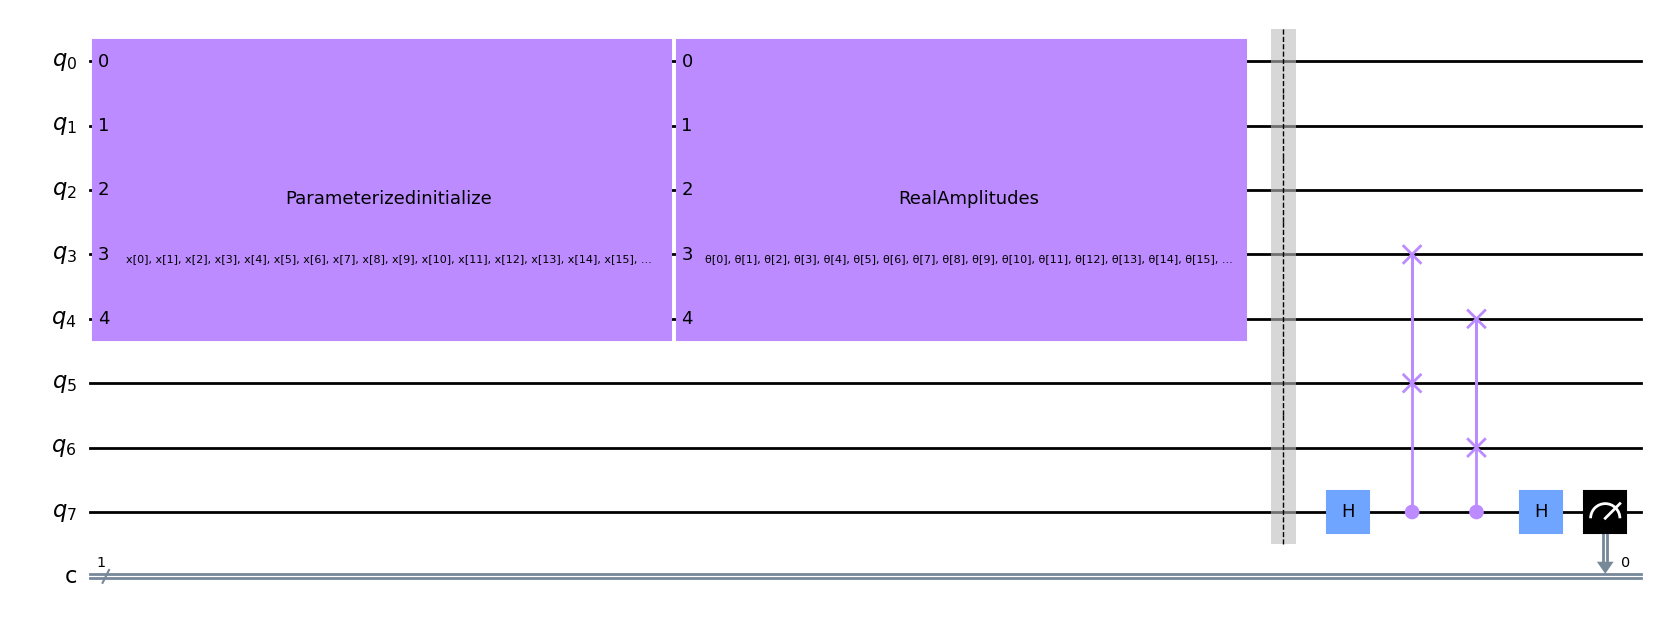

In [31]:
num_latent = 3
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw(output="mpl", style="clifford")

In [35]:
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [42]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

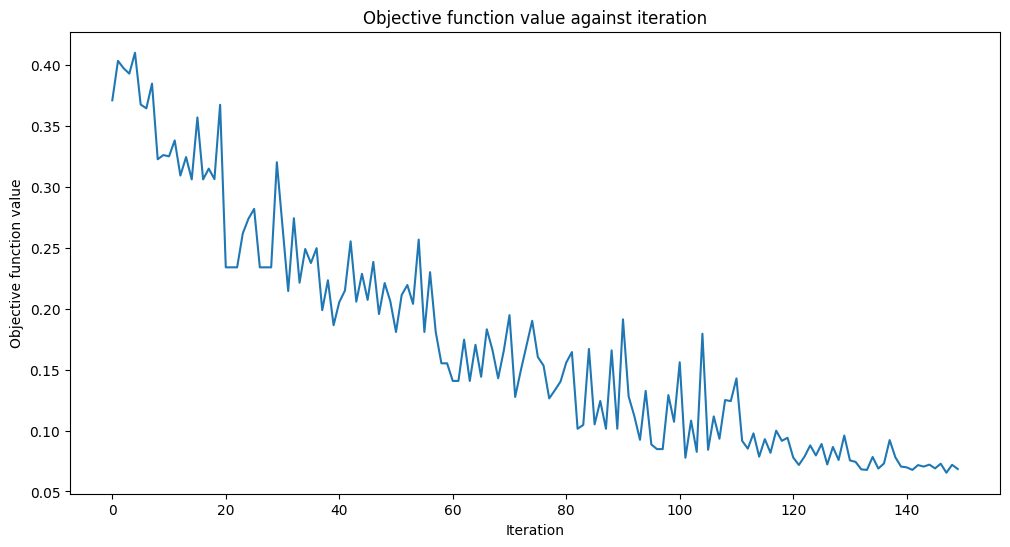

Fit in 29.73 seconds


In [44]:
opt = COBYLA(maxiter=150)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

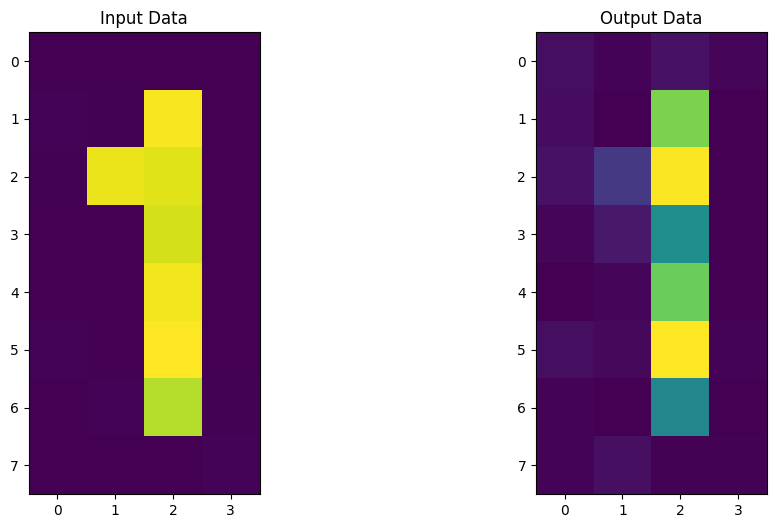

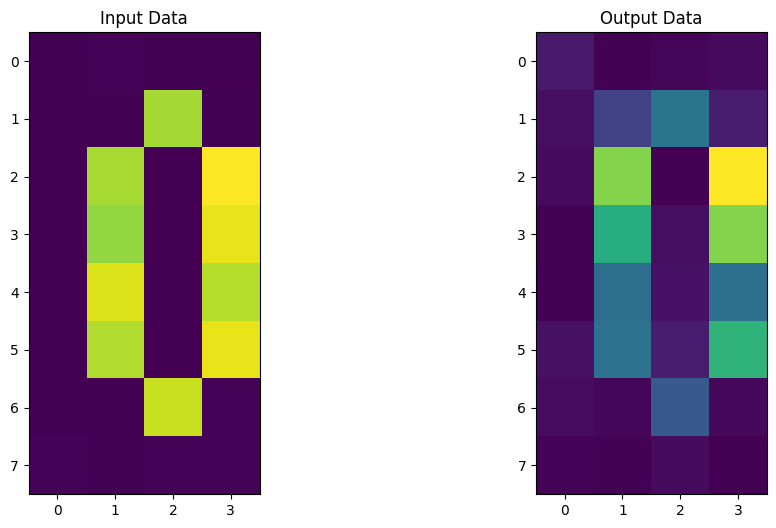

In [45]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

# sample new images
test_images, test_labels = get_dataset_digits(2, draw=False)
for image, label in zip(test_images, test_labels):
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, (8, 4))

    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (8, 4))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original_sv)
    ax1.set_title("Input Data")
    ax2.imshow(output_sv)
    ax2.set_title("Output Data")
    plt.show()